In [10]:
import numpy as np
import pygad
import tree_representation
import csv
import matplotlib.pyplot as plt
import pickle
import math

In [113]:
xs, ys, target = None, None, None

In [114]:
def fitness_func(ga_instance, solution, solution_idx):
  tree = tree_representation.fromIntArray(solution)
  fit = tree_representation.fitness(tree, xs, ys)
  return fit

def crossover_func(parents, offspring_size, ga_instance):
  offspring = []
  t1, t2 = tree_representation.fromIntArray(parents[0]), tree_representation.fromIntArray(parents[1])
  
  while len(offspring) != offspring_size[0]:
    child, _ = tree_representation.crossover_tree(t1, t2)

    try:
      offspring.append(tree_representation.toIntArray(child))
    except IndexError:
      print("Not crossovering")
    
  return np.array(offspring)

def mutation_func(offspring, ga_instance):
  new_offspring = []

  for t_numerical in offspring:
    t = tree_representation.fromIntArray(t_numerical)
    
    if (np.random.rand() < ga_instance.mutation_probability):
      t = tree_representation.mutate_tree(t)
    new_offspring.append(tree_representation.toIntArray(t))

  return np.array(new_offspring)

In [115]:
def predict_function():
    initial_population = [tree_representation.toIntArray(tree_representation.generate_random_tree()) for _ in range(5000)]

    ga_instance = pygad.GA(num_generations=100,
                        num_parents_mating=2,
                        initial_population=initial_population,
                        fitness_func=fitness_func,
                        keep_elitism=10,
                        crossover_type=crossover_func,
                        mutation_type=mutation_func,
                        gene_type=np.int8,
                        mutation_probability=1,
                        stop_criteria="saturate_10",
                        parallel_processing=20
                        )

    ga_instance.run()

    solution, solution_fitness, solution_idx = ga_instance.best_solution()

    return tree_representation.fromIntArray(solution), solution_fitness

In [3]:
best_models = [(-float("inf"), None, None) for _ in range(100)]
tree_representation.Node.ENABLE_EXTRA_OPERATORS = True

equation_indices = range(2, 9) 
skip_indices = [36, 40]

with open("custom_dataset.csv") as file:
    reader = csv.reader(file)

    index = 1
    for row in reader:
        print("processing " + str(index))
        target = row[0]

        xs = np.fromstring(row[1][1:-1], sep=", ")
        ys = np.fromstring(row[2][1:-1], sep=", ")

        if index in skip_indices:
            index += 1
            continue

        if index in equation_indices:
            best_model, best_fitness = predict_function(index)
            if best_fitness > best_models[index][0]:
                best_models[index] = (best_fitness, best_model, target)
        index += 1


# save best models to file
with open('best_models_custom.pkl', 'wb') as file:
    pickle.dump(best_models, file)


processing 1
processing 2


NameError: name 'predict_function' is not defined

In [7]:
# load predictions from file
with open('best_models.pkl', 'rb') as file:
    best_models = pickle.load(file)

In [19]:
def graph_predictions(best_models, indices):
    with open("dataset.csv") as file:
        reader = csv.reader(file)

        index = 1
        for row in reader:
            if index not in indices:
                continue

            target = row[0]

            xs = np.fromstring(row[1][1:-1], sep=", ")
            ys = np.fromstring(row[2][1:-1], sep=", ")
            fitness, model, target = best_models[index]
            
            if model != None:
                print("Target: ", target)
                print("Best solution", model)
                print("Best fitness", fitness)

                plt.title(f"Index: {index - 1}")
                plt.plot(xs, ys, color='green')
                plt.plot(xs, [model.evaluate(x) for x in xs], color='blue')
                plt.show()
            
            index += 1

Target:  ((x ** 4) - 6)
Best solution + -6.00 ^ x 4.00
Best fitness -0.0005


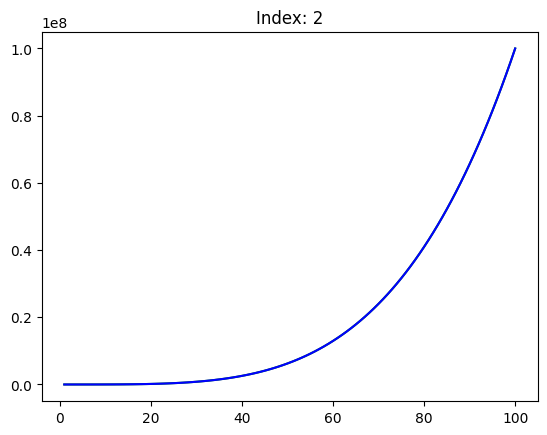

Target:  (((x / 8) * 2) + 1)
Best solution + - / + + -5.00 - -7.00 x -6.00 - - + - 4.00 8.00 3.00 3.00 1.00 7.00 7.00
Best fitness -209.3157375


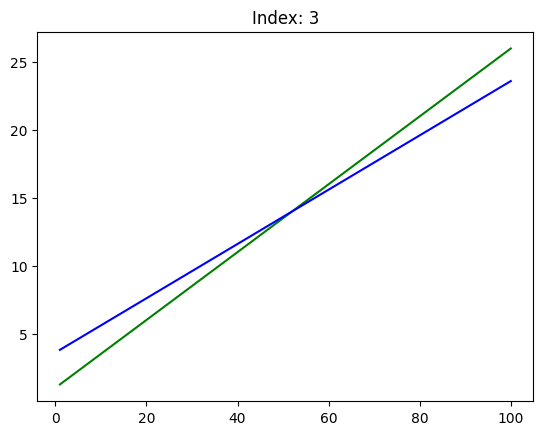

Target:  (((x - 1) - 3) / 5)
Best solution / x 5.00
Best fitness -64.01950000000001


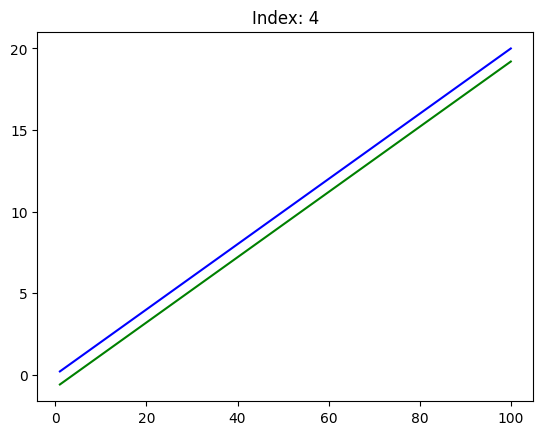

Target:  (x * 5)
Best solution * x 5.00
Best fitness -0.00030000000000000003


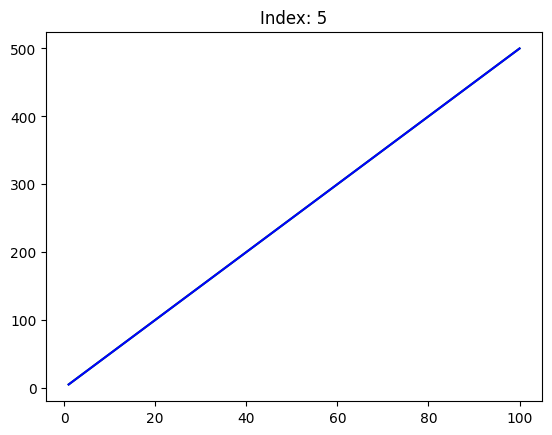

Target:  (x + 2)
Best solution - - x + -3.00 4.00 - * * -1.00 -3.00 ^ - -6.00 -5.00 9.00 / 0.00 * 5.00 ^ 6.00 5.00
Best fitness -0.0023


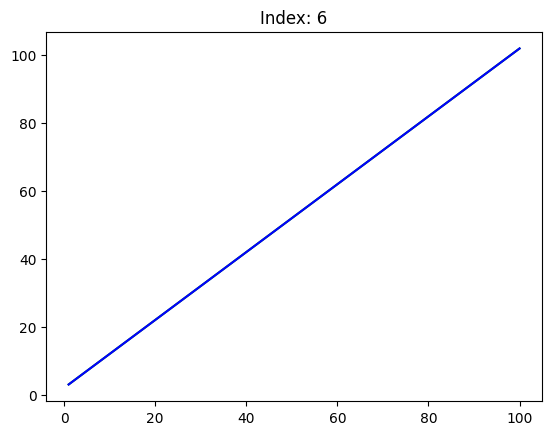

In [23]:
# indices = range(100)
indices = [1, 2, 3, 4, 5, 6]

graph_predictions(best_models=best_models, indices=indices)